In [ ]:
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(palette='summer')

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install datasets

In [ ]:
!pip install transformers

In [ ]:
!pip install evaluate

In [ ]:
import transformers
from datasets import load_dataset
import evaluate

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader

# Загружаем датасет
file_path = 'drive/MyDrive/data_problems_translated.xlsx'
df = pd.read_excel(file_path)

# Разделение на тренировочный, тестовый и валидационный наборы данных
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)

# Инициализация токенизатора
tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")

# Создание кастомного датасета
class DataProblemsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.texts = dataframe["problem_text"].tolist()
        self.labels = dataframe["topic"].astype('category').cat.codes.tolist()  # Категоризируем классы
        print(f"всего классов: {len(set(self.labels))}")

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item["labels"] = torch.tensor(label, dtype=torch.long)
        return item

# Подготовка DataLoader для обучения
train_dataset = DataProblemsDataset(train_df, tokenizer)
val_dataset = DataProblemsDataset(val_df, tokenizer)
test_dataset = DataProblemsDataset(test_df, tokenizer)

# Параметры DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Проверка размеров наборов данных
print("Размер тренировочного набора:", len(train_df))
print("Размер валидационного набора:", len(val_df))
print("Размер тестового набора:", len(test_df))

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


всего классов: 7
всего классов: 7
всего классов: 7
Размер тренировочного набора: 3163
Размер валидационного набора: 1055
Размер тестового набора: 1055


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
train_df.head()

,Unnamed: 0,problem_text,topic
986,986,"In the town of Little 15 phones, can they be c...",graphs
4156,4156,Buck was full of water. This water was equally...,number_theory
1960,1960,The difference between p and each of these num...,number_theory
5270,5270,"The correct 5,000-column has a 2001 vertebrate...",dirichlet
111,111,"In the company, every two people have exactly ...",graphs


Класс для использования backbone

In [ ]:
import torch
import torch.nn as nn
from transformers import AutoModel, AutoConfig
from typing import Union

class TransformerClassificationModel(nn.Module):
    def __init__(self, base_transformer_model: Union[str, nn.Module], num_classes: int = 7):
        super(TransformerClassificationModel, self).__init__()

        # Загружаем конфигурацию и модель (backbone) из Hugging Face
        if isinstance(base_transformer_model, str):
            self.config = AutoConfig.from_pretrained(base_transformer_model)
            self.backbone = AutoModel.from_pretrained(base_transformer_model, config=self.config)
        elif isinstance(base_transformer_model, nn.Module):
            self.backbone = base_transformer_model
            self.config = self.backbone.config
        else:
            raise ValueError("base_transformer_model должен быть строкой (название модели) или объектом nn.Module")

        # Дополнительный классификационный слой
        # Используем выходной размер скрытого слоя трансформера для настройки линейного слоя
        self.classifier = nn.Linear(self.config.hidden_size, num_classes)

    def forward(self, inputs):
        # Пропускаем данные через backbone
        backbone_outputs = self.backbone(**inputs)

        # Обычно используется [CLS] токен для классификации, который находится в нулевой позиции
        # Возьмем скрытые состояния первого токена ([CLS]) из последнего слоя
        cls_output = backbone_outputs.last_hidden_state[:, 0, :]

        # Пропускаем через классификационный слой
        logits = self.classifier(cls_output)

        # Возвращаем словарь с логитами
        outputs = {"logits": logits}
        return outputs

Функция для заморозки backbone

In [ ]:
def freeze_backbone_function(model: TransformerClassificationModel):
    for param in model.backbone.parameters():
        param.requires_grad = False

    return model

Дообучение трансформера

In [ ]:
import copy
import torch
from torch.optim import Adam
from tqdm import tqdm

def train_transformer(transformer_model, train_loader, val_loader=None, freeze_backbone=True,
                      num_epochs=3, learning_rate=1e-5, device="cuda" if torch.cuda.is_available() else "cpu"):
    # Копируем модель, чтобы не изменять оригинал
    model = copy.deepcopy(transformer_model).to(device)

    # Замораживаем backbone, если это указано
    if freeze_backbone:
        model = freeze_backbone_function(model)

    # Определяем оптимизатор
    optimizer = Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

    # Режим обучения
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        # Прогресс-бар для удобного отслеживания обучения
        progress_bar = tqdm(train_loader, desc=f"Эпоха {epoch + 1}/{num_epochs}")

        for batch in progress_bar:
            # Подготавливаем данные для передачи на устройство
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямое распространение и расчет потерь
            outputs = model(inputs)
            logits = outputs["logits"]
            loss = torch.nn.functional.cross_entropy(logits, labels)

            # Обратное распространение и обновление весов
            loss.backward()
            optimizer.step()

            # Накопление общей потери для отслеживания
            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        # Средняя потеря за эпоху
        avg_loss = total_loss / len(train_loader)
        print(f"Средняя потеря за эпоху {epoch + 1}: {avg_loss:.4f}")

        # Оценка на валидационном наборе, если он предоставлен
        if val_loader:
            model.eval()
            val_loss = 0
            correct_predictions = 0
            total_predictions = 0

            with torch.no_grad():
                for val_batch in val_loader:
                    inputs = {key: val.to(device) for key, val in val_batch.items() if key != 'labels'}
                    labels = val_batch['labels'].to(device)
                    outputs = model(inputs)
                    logits = outputs["logits"]

                    val_loss += torch.nn.functional.cross_entropy(logits, labels).item()

                    # Предсказания и подсчет точных
                    preds = torch.argmax(logits, dim=1)
                    correct_predictions += (preds == labels).sum().item()
                    total_predictions += labels.size(0)

            avg_val_loss = val_loss / len(val_loader)
            accuracy = correct_predictions / total_predictions
            print(f"Валидационная потеря: {avg_val_loss:.4f}, Точность: {accuracy:.4f}")

            # Возвращаемся в режим обучения
            model.train()

    # Возвращаем дообученную модель
    finetuned_model = model
    return finetuned_model

Обучение

cointegrated/rubert-tiny2

In [ ]:
# Дообучение с замороженным backbone
rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2", num_classes=7)
rubert_tiny_finetuned_with_freezed_backbone = train_transformer(
    rubert_tiny_transformer_model, train_loader, val_loader, freeze_backbone=True, num_epochs=10
)

# Дообучение с размороженным backbone
rubert_tiny_transformer_model = TransformerClassificationModel("cointegrated/rubert-tiny2", num_classes=7)
rubert_tiny_full_finetuned = train_transformer(
    rubert_tiny_transformer_model, train_loader, val_loader, freeze_backbone=False, num_epochs=10
)

Эпоха 1/10: 100%|██████████| 198/198 [00:06<00:00, 32.16it/s, loss=1.9]


Средняя потеря за эпоху 1: 1.8776
Валидационная потеря: 1.8349, Точность: 0.4161


Эпоха 2/10: 100%|██████████| 198/198 [00:04<00:00, 42.68it/s, loss=1.46]


Средняя потеря за эпоху 2: 1.8014
Валидационная потеря: 1.7650, Точность: 0.4493


Эпоха 3/10: 100%|██████████| 198/198 [00:03<00:00, 59.73it/s, loss=1.92]


Средняя потеря за эпоху 3: 1.7385
Валидационная потеря: 1.7095, Точность: 0.4540


Эпоха 4/10: 100%|██████████| 198/198 [00:03<00:00, 50.48it/s, loss=1.59]


Средняя потеря за эпоху 4: 1.6926
Валидационная потеря: 1.6658, Точность: 0.4531


Эпоха 5/10: 100%|██████████| 198/198 [00:03<00:00, 54.22it/s, loss=1.47]


Средняя потеря за эпоху 5: 1.6561
Валидационная потеря: 1.6312, Точность: 0.4521


Эпоха 6/10: 100%|██████████| 198/198 [00:03<00:00, 61.02it/s, loss=1.72]


Средняя потеря за эпоху 6: 1.6239
Валидационная потеря: 1.6034, Точность: 0.4521


Эпоха 7/10: 100%|██████████| 198/198 [00:03<00:00, 56.52it/s, loss=1.57]


Средняя потеря за эпоху 7: 1.6019
Валидационная потеря: 1.5809, Точность: 0.4521


Эпоха 8/10: 100%|██████████| 198/198 [00:04<00:00, 48.02it/s, loss=1.65]


Средняя потеря за эпоху 8: 1.5838
Валидационная потеря: 1.5625, Точность: 0.4521


Эпоха 9/10: 100%|██████████| 198/198 [00:03<00:00, 61.29it/s, loss=1.39]


Средняя потеря за эпоху 9: 1.5678
Валидационная потеря: 1.5467, Точность: 0.4531


Эпоха 10/10: 100%|██████████| 198/198 [00:03<00:00, 62.68it/s, loss=1.1]


Средняя потеря за эпоху 10: 1.5516
Валидационная потеря: 1.5332, Точность: 0.4531


Эпоха 1/10: 100%|██████████| 198/198 [00:07<00:00, 27.41it/s, loss=1.28]


Средняя потеря за эпоху 1: 1.5119
Валидационная потеря: 1.2986, Точность: 0.5346


Эпоха 2/10: 100%|██████████| 198/198 [00:06<00:00, 28.87it/s, loss=0.745]


Средняя потеря за эпоху 2: 1.2476
Валидационная потеря: 1.1298, Точность: 0.5953


Эпоха 3/10: 100%|██████████| 198/198 [00:07<00:00, 27.74it/s, loss=0.947]


Средняя потеря за эпоху 3: 1.1254
Валидационная потеря: 1.0592, Точность: 0.6180


Эпоха 4/10: 100%|██████████| 198/198 [00:07<00:00, 27.88it/s, loss=1.11]


Средняя потеря за эпоху 4: 1.0454
Валидационная потеря: 1.0229, Точность: 0.6322


Эпоха 5/10: 100%|██████████| 198/198 [00:06<00:00, 29.57it/s, loss=1.33]


Средняя потеря за эпоху 5: 0.9786
Валидационная потеря: 0.9895, Точность: 0.6322


Эпоха 6/10: 100%|██████████| 198/198 [00:08<00:00, 24.25it/s, loss=0.858]


Средняя потеря за эпоху 6: 0.9290
Валидационная потеря: 0.9662, Точность: 0.6427


Эпоха 7/10: 100%|██████████| 198/198 [00:07<00:00, 26.65it/s, loss=1.1]


Средняя потеря за эпоху 7: 0.8835
Валидационная потеря: 0.9597, Точность: 0.6284


Эпоха 8/10: 100%|██████████| 198/198 [00:07<00:00, 27.22it/s, loss=0.608]


Средняя потеря за эпоху 8: 0.8421
Валидационная потеря: 0.9442, Точность: 0.6370


Эпоха 9/10: 100%|██████████| 198/198 [00:06<00:00, 29.96it/s, loss=0.811]


Средняя потеря за эпоху 9: 0.8149
Валидационная потеря: 0.9420, Точность: 0.6360


Эпоха 10/10: 100%|██████████| 198/198 [00:07<00:00, 27.84it/s, loss=0.869]


Средняя потеря за эпоху 10: 0.7737
Валидационная потеря: 0.9436, Точность: 0.6237


tbs17/MathBert

In [ ]:
# Загрузка токенайзера и модели MathBert
mathbert_tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBert")

# Создаем новый DataLoader для MathBert, если требуется, можно использовать уже подготовленные данные
train_dataset_mathbert = DataProblemsDataset(train_df, mathbert_tokenizer)
val_dataset_mathbert = DataProblemsDataset(val_df, mathbert_tokenizer)
test_dataset_mathbert = DataProblemsDataset(test_df, mathbert_tokenizer)

train_loader_mathbert = DataLoader(train_dataset_mathbert, batch_size=batch_size, shuffle=True)
val_loader_mathbert = DataLoader(val_dataset_mathbert, batch_size=batch_size)
test_loader_mathbert = DataLoader(test_dataset_mathbert, batch_size=batch_size)

# Дообучение с замороженным backbone для MathBert
mathbert_transformer_model = TransformerClassificationModel("tbs17/MathBert", num_classes=7)
mathbert_finetuned_with_freezed_backbone = train_transformer(
    mathbert_transformer_model, train_loader_mathbert, val_loader_mathbert, freeze_backbone=True,
    num_epochs=10, learning_rate=1e-5, device=device
)

# Дообучение с размороженным backbone для MathBert
mathbert_transformer_model_unfreeze = TransformerClassificationModel("tbs17/MathBert", num_classes=7)
mathbert_full_finetuned = train_transformer(
    mathbert_transformer_model_unfreeze, train_loader_mathbert, val_loader_mathbert, freeze_backbone=False,
    num_epochs=10, learning_rate=1e-5, device=device
)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


всего классов: 7
всего классов: 7
всего классов: 7


Эпоха 1/10: 100%|██████████| 198/198 [00:23<00:00,  8.31it/s, loss=1.58]


Средняя потеря за эпоху 1: 1.8540
Валидационная потеря: 1.7239, Точность: 0.3810


Эпоха 2/10: 100%|██████████| 198/198 [00:23<00:00,  8.27it/s, loss=1.32]


Средняя потеря за эпоху 2: 1.6950
Валидационная потеря: 1.6350, Точность: 0.4379


Эпоха 3/10: 100%|██████████| 198/198 [00:23<00:00,  8.55it/s, loss=1.93]


Средняя потеря за эпоху 3: 1.6519
Валидационная потеря: 1.6000, Точность: 0.4427


Эпоха 4/10: 100%|██████████| 198/198 [00:23<00:00,  8.38it/s, loss=1.58]


Средняя потеря за эпоху 4: 1.6259
Валидационная потеря: 1.5766, Точность: 0.4464


Эпоха 5/10: 100%|██████████| 198/198 [00:23<00:00,  8.40it/s, loss=1.59]


Средняя потеря за эпоху 5: 1.5892
Валидационная потеря: 1.5568, Точность: 0.4474


Эпоха 6/10: 100%|██████████| 198/198 [00:23<00:00,  8.43it/s, loss=1.72]


Средняя потеря за эпоху 6: 1.5670
Валидационная потеря: 1.5385, Точность: 0.4483


Эпоха 7/10: 100%|██████████| 198/198 [00:23<00:00,  8.40it/s, loss=1.9]


Средняя потеря за эпоху 7: 1.5563
Валидационная потеря: 1.5205, Точность: 0.4493


Эпоха 8/10: 100%|██████████| 198/198 [00:23<00:00,  8.39it/s, loss=1.61]


Средняя потеря за эпоху 8: 1.5403
Валидационная потеря: 1.5037, Точность: 0.4502


Эпоха 9/10: 100%|██████████| 198/198 [00:23<00:00,  8.39it/s, loss=1.22]


Средняя потеря за эпоху 9: 1.5244
Валидационная потеря: 1.4876, Точность: 0.4531


Эпоха 10/10: 100%|██████████| 198/198 [00:23<00:00,  8.41it/s, loss=1.33]


Средняя потеря за эпоху 10: 1.4974
Валидационная потеря: 1.4734, Точность: 0.4559


Эпоха 1/10: 100%|██████████| 198/198 [01:09<00:00,  2.84it/s, loss=1.49]


Средняя потеря за эпоху 1: 1.2396
Валидационная потеря: 1.0258, Точность: 0.6152


Эпоха 2/10: 100%|██████████| 198/198 [01:09<00:00,  2.83it/s, loss=0.857]


Средняя потеря за эпоху 2: 0.9245
Валидационная потеря: 1.0163, Точность: 0.6180


Эпоха 3/10: 100%|██████████| 198/198 [01:09<00:00,  2.84it/s, loss=0.563]


Средняя потеря за эпоху 3: 0.7580
Валидационная потеря: 1.0056, Точность: 0.5934


Эпоха 4/10: 100%|██████████| 198/198 [01:09<00:00,  2.83it/s, loss=0.901]


Средняя потеря за эпоху 4: 0.5928
Валидационная потеря: 1.1641, Точность: 0.6000


Эпоха 5/10: 100%|██████████| 198/198 [01:09<00:00,  2.83it/s, loss=0.317]


Средняя потеря за эпоху 5: 0.4849
Валидационная потеря: 1.2511, Точность: 0.5867


Эпоха 6/10: 100%|██████████| 198/198 [01:09<00:00,  2.83it/s, loss=1.12]


Средняя потеря за эпоху 6: 0.4132
Валидационная потеря: 1.3468, Точность: 0.5924


Эпоха 7/10: 100%|██████████| 198/198 [01:09<00:00,  2.84it/s, loss=0.268]


Средняя потеря за эпоху 7: 0.3705
Валидационная потеря: 1.3513, Точность: 0.5829


Эпоха 8/10: 100%|██████████| 198/198 [01:09<00:00,  2.83it/s, loss=0.243]


Средняя потеря за эпоху 8: 0.3352
Валидационная потеря: 1.4241, Точность: 0.5820


Эпоха 9/10: 100%|██████████| 198/198 [01:09<00:00,  2.83it/s, loss=0.515]


Средняя потеря за эпоху 9: 0.3339
Валидационная потеря: 1.4881, Точность: 0.5848


Эпоха 10/10: 100%|██████████| 198/198 [01:10<00:00,  2.81it/s, loss=0.498]


Средняя потеря за эпоху 10: 0.3154
Валидационная потеря: 1.5602, Точность: 0.5820


Скоры получились где-то лучше, где-то хуже. Тем не менее, изначально на MathBert скоры росли быстрее, но в дальнейшем, модели переобучились. Это произошло по причине специального обучения MathBert для работы с математическими терминами, что подходит к предметной области данной задачи.

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Загружаем токенайзеры и модели
rubert_tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny2")
mathbert_tokenizer = AutoTokenizer.from_pretrained("tbs17/MathBert")
rubert_model = AutoModel.from_pretrained("cointegrated/rubert-tiny2", output_attentions=True)
mathbert_model = AutoModel.from_pretrained("tbs17/MathBert", output_attentions=True)

# Выбираем несколько текстов из датасета
sample_texts = [
    "To prove that the sum of the numbers of the exact square cannot be equal to 5",
    "Find the product of all prime numbers less than 20",
    "Show that every even integer greater than 2 can be written as the sum of two primes"
]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Текст: To prove that the sum of the numbers of the exact square cannot be equal to 5

Карта внимания для модели RuBERT-tiny2


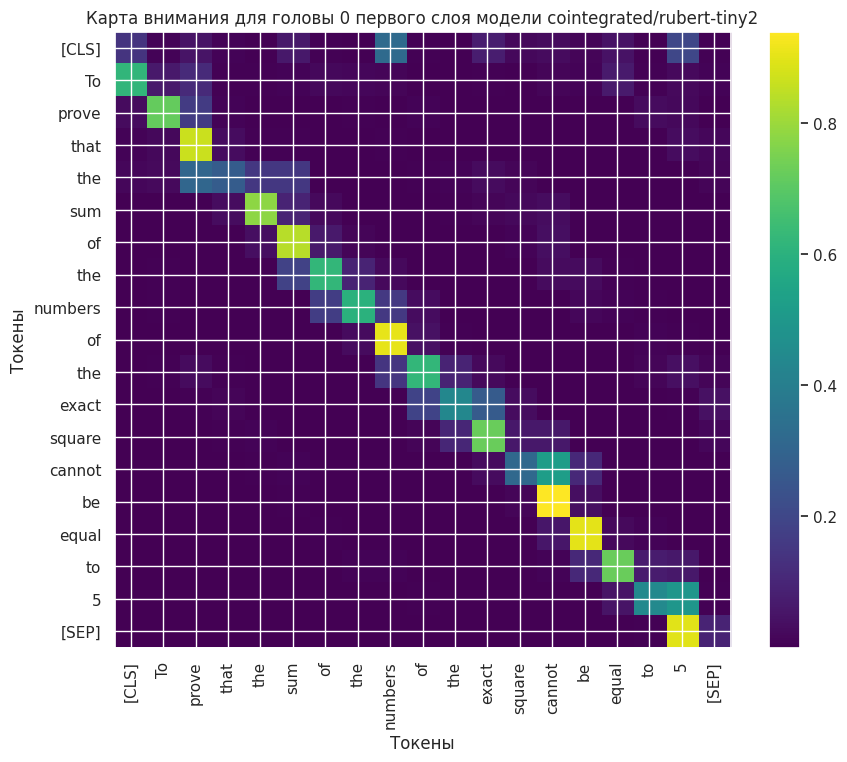

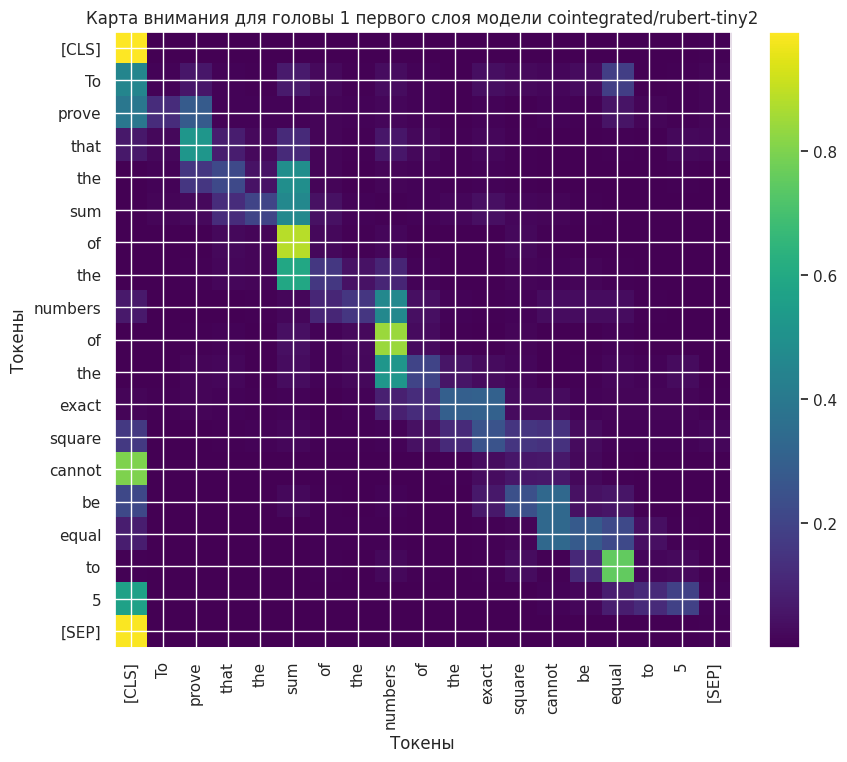

Карта внимания для модели MathBert


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


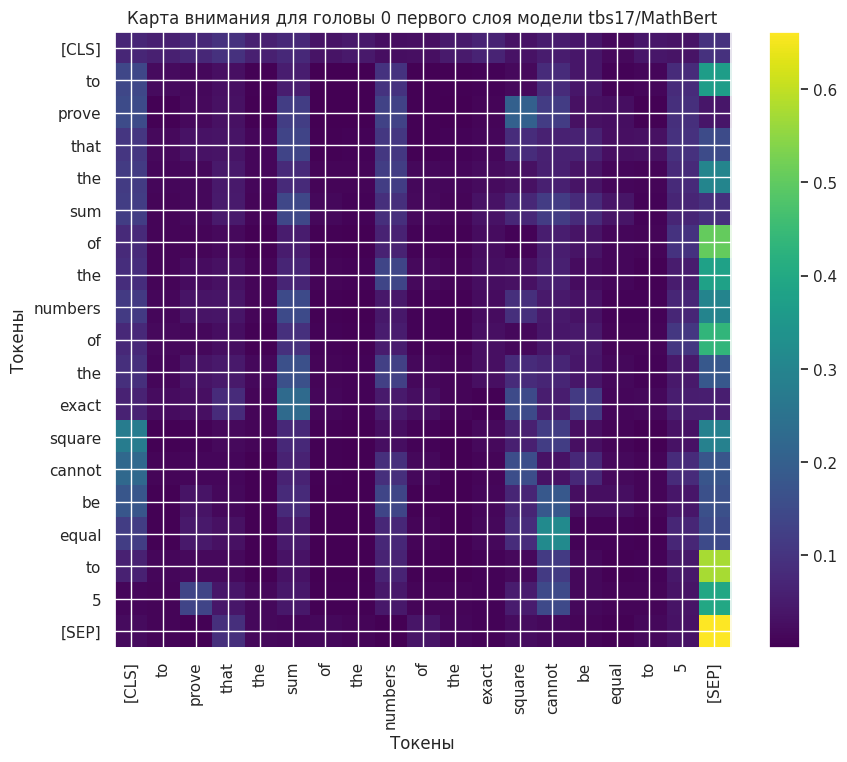

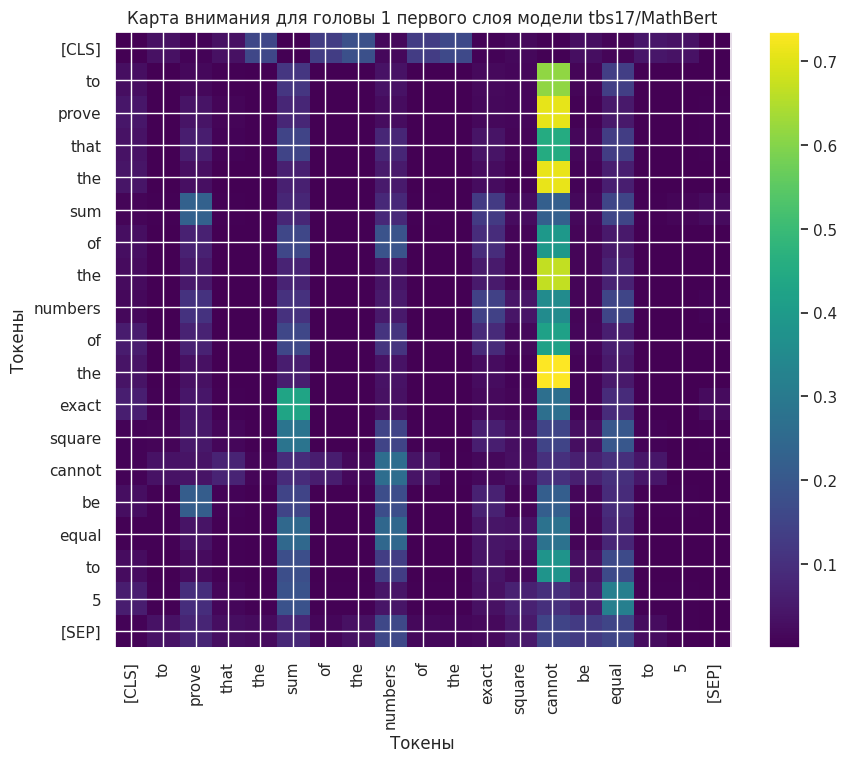

Текст: Find the product of all prime numbers less than 20

Карта внимания для модели RuBERT-tiny2


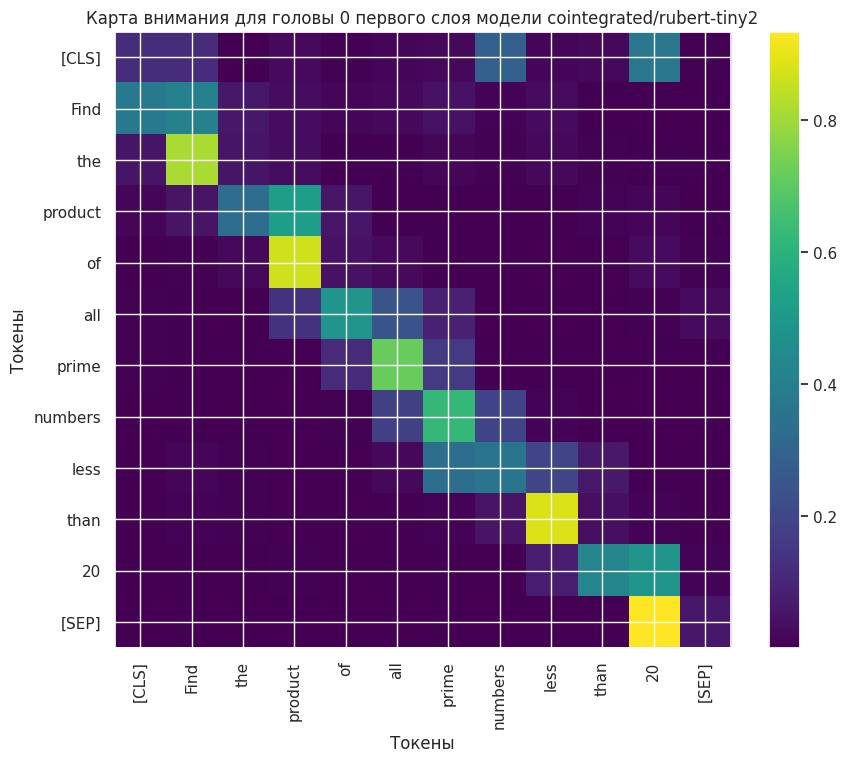

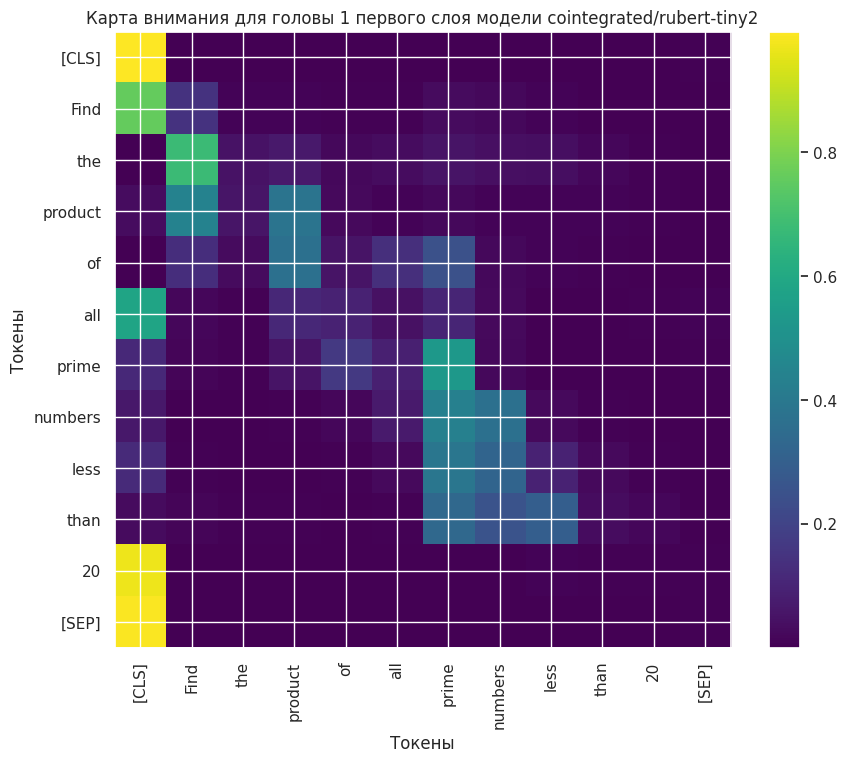

Карта внимания для модели MathBert


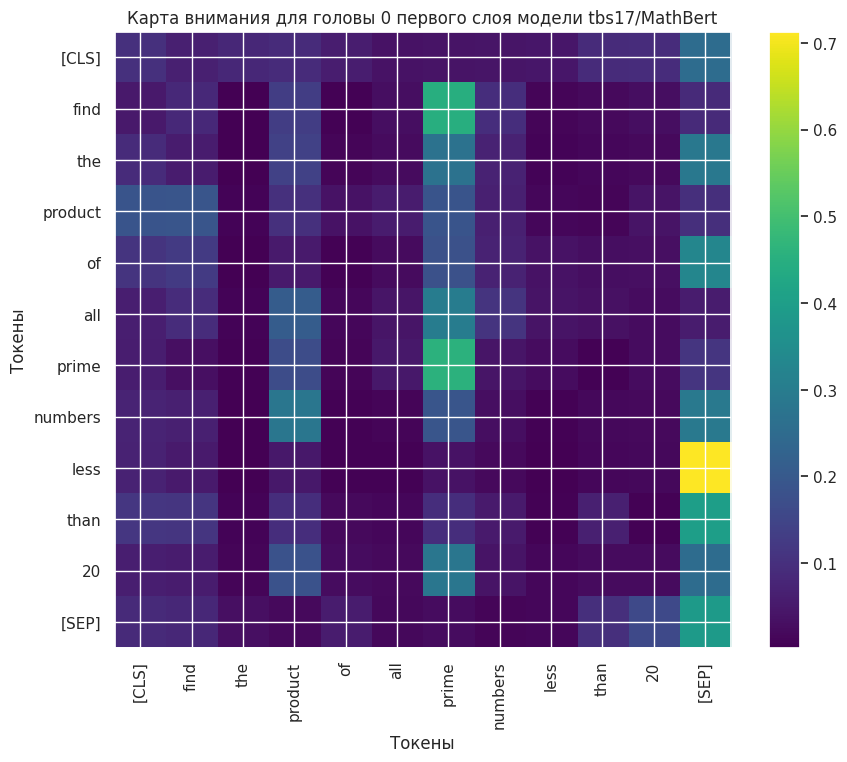

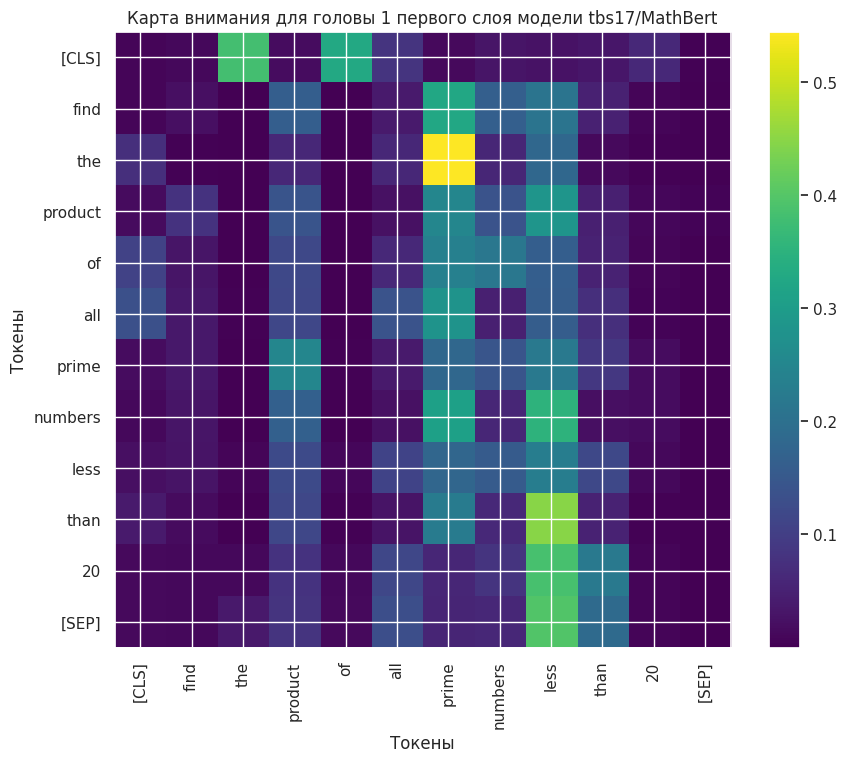

Текст: Show that every even integer greater than 2 can be written as the sum of two primes

Карта внимания для модели RuBERT-tiny2


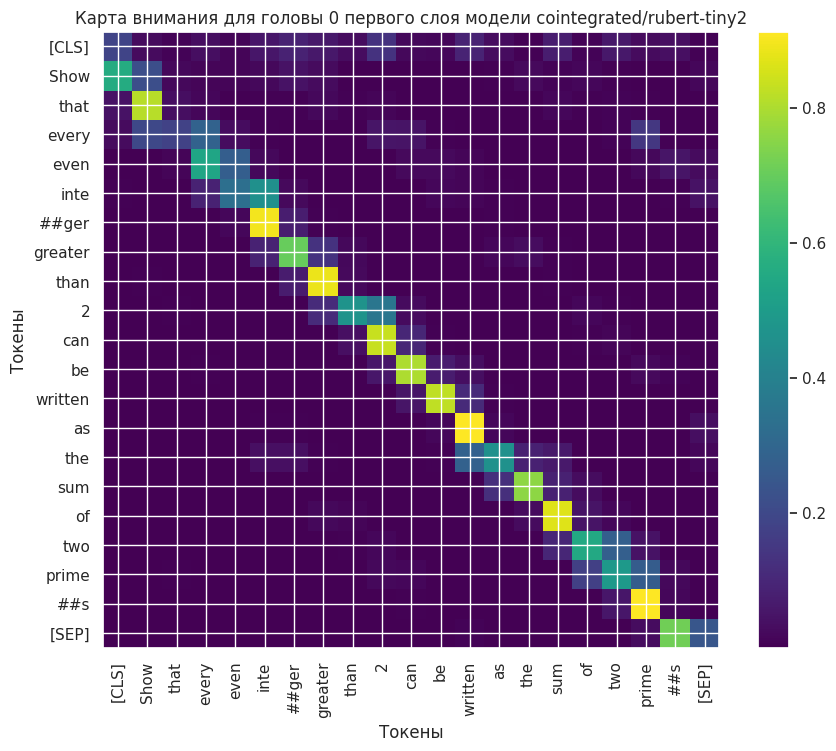

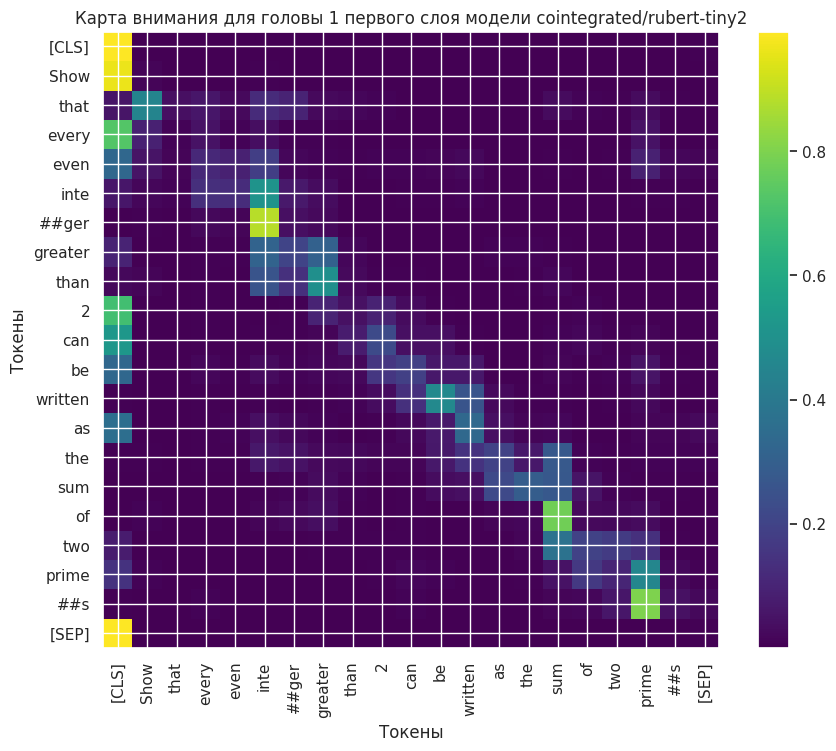

Карта внимания для модели MathBert


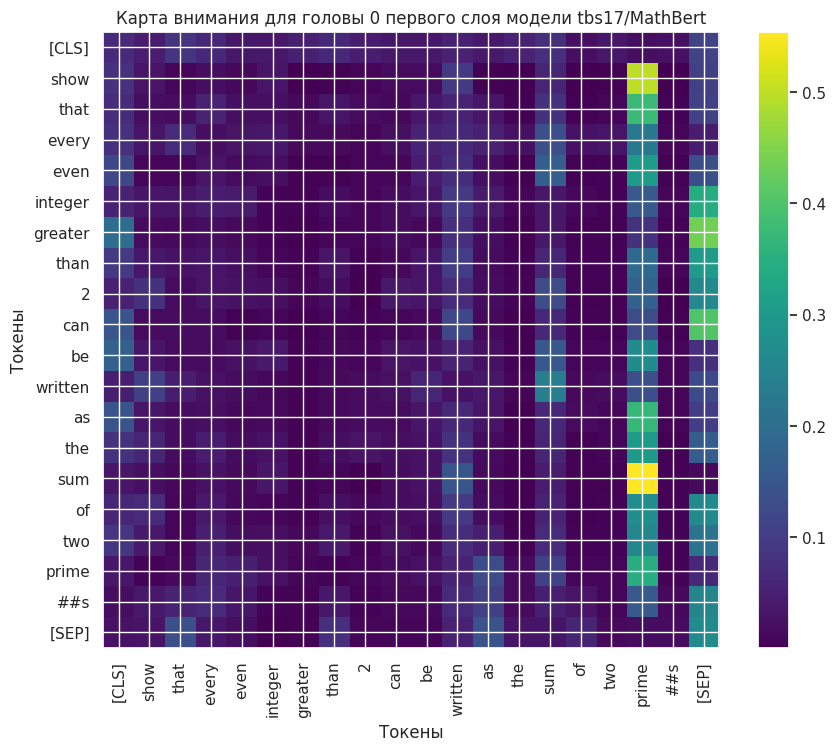

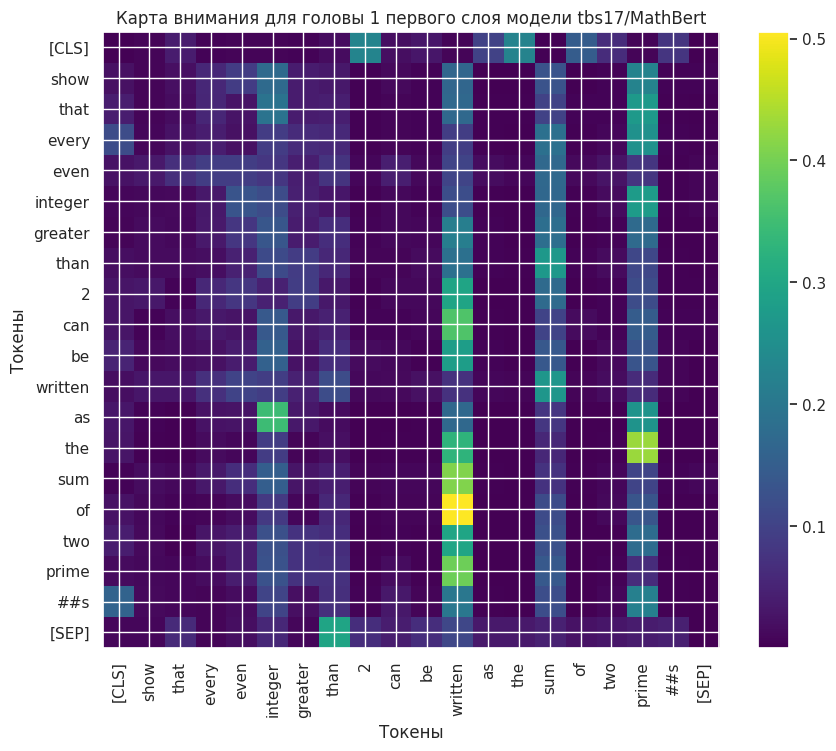

In [ ]:
for text in sample_texts:
    print(f"Текст: {text}\n")
    print("Карта внимания для модели RuBERT-tiny2")
    draw_first_layer_attention_maps(attention_head_ids=[0, 1], text=text, model=rubert_model, tokenizer=rubert_tokenizer)

    print("Карта внимания для модели MathBert")
    draw_first_layer_attention_maps(attention_head_ids=[0, 1], text=text, model=mathbert_model, tokenizer=mathbert_tokenizer)

RuBERT-tiny2: головы фиксируют токены начала и конца предложения и уделяют внимание специфическим контекстным словам (например - "sum", "prime").
MathBert: также фиксирует служебные токены, также указывает на большее внимание к математическим терминам. Также обращает внимание на числа.

In [ ]:
from transformers import AutoTokenizer
from typing import List

def draw_first_layer_attention_maps(attention_head_ids: List[int], text: str, model: TransformerClassificationModel):
    # Проверим, есть ли модель на GPU, и при необходимости перенесем её
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    # Токенизируем входной текст
    tokenizer = AutoTokenizer.from_pretrained(model.backbone.config._name_or_path)
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)

    # Получаем значения внимания из модели
    with torch.no_grad():
        # Убедимся, что в модели включен вывод значений внимания
        outputs = model.backbone(**inputs, output_attentions=True)

    # Извлекаем тензор внимания для первого слоя (внимание имеет размер: [num_heads, seq_len, seq_len])
    attentions = outputs.attentions[0]  # первый слой внимания
    tokenized_text = tokenizer.convert_ids_to_tokens(inputs["input_ids"].squeeze().tolist())

    # Отрисовываем карты внимания для каждой из выбранных голов
    for head_id in attention_head_ids:
        if head_id >= attentions.size(1):
            print(f"Недопустимый ID головы {head_id}. Допустимые значения от 0 до {attentions.size(1) - 1}.")
            continue

        # Получаем карту внимания для заданной головы
        attention = attentions[0, head_id].cpu().numpy()  # выбираем первый элемент батча, затем нужную голову

        # Визуализируем карту внимания
        plt.figure(figsize=(10, 8))
        plt.imshow(attention, cmap="viridis")
        plt.colorbar()
        plt.xticks(range(len(tokenized_text)), tokenized_text, rotation=90)
        plt.yticks(range(len(tokenized_text)), tokenized_text)
        plt.title(f"Карта внимания для головы {head_id} первого слоя")
        plt.xlabel("Токены")
        plt.ylabel("Токены")
        plt.show()

In [ ]:
# Убедимся, что дообученные версии моделей загружены
# Используем те, которые дообучались с незамороженным backbone
rubert_finetuned_model = rubert_tiny_full_finetuned
mathbert_finetuned_model = mathbert_full_finetuned

# Тексты из датасета для анализа
sample_texts = [
    "To prove that the sum of the numbers of the exact square cannot be equal to 5",
    "Find the product of all prime numbers less than 20",
    "Show that every even integer greater than 2 can be written as the sum of two primes"
]

Текст: To prove that the sum of the numbers of the exact square cannot be equal to 5

Карта внимания для дообученной модели RuBERT-tiny2


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


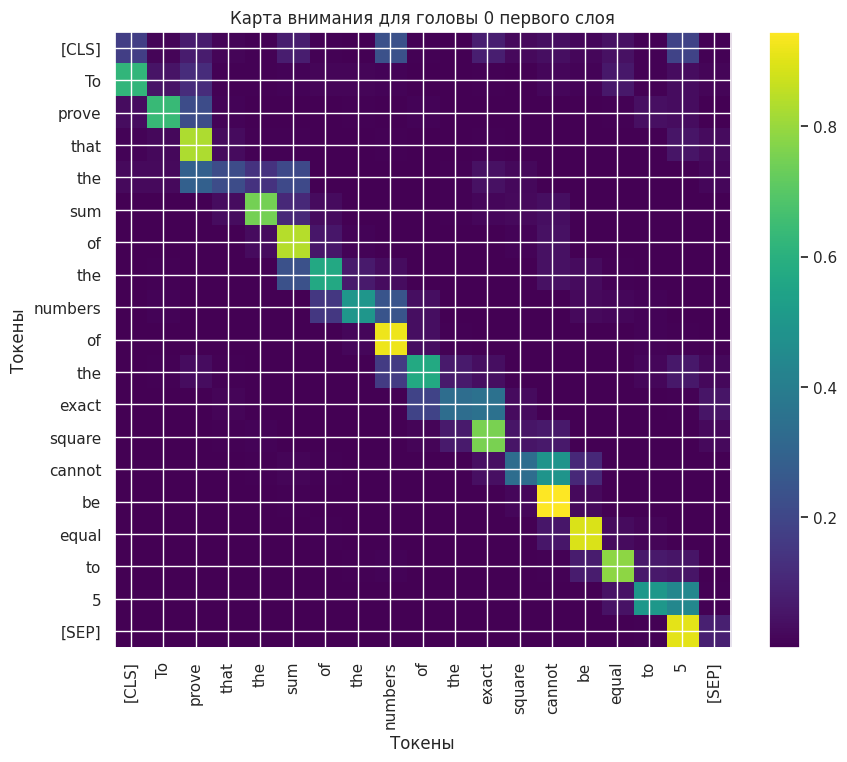

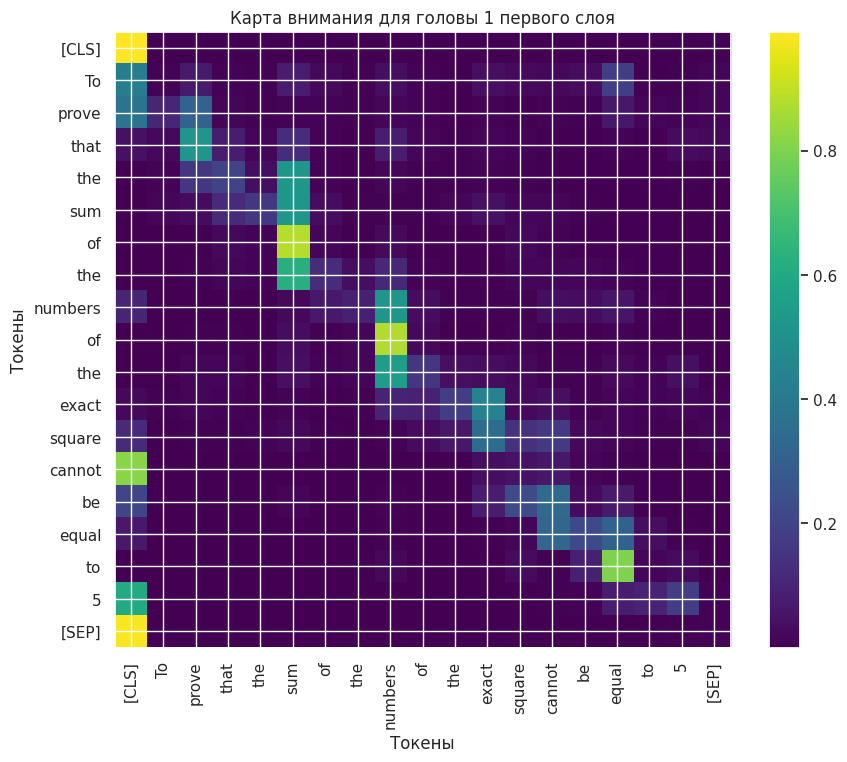

Карта внимания для дообученной модели MathBert


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


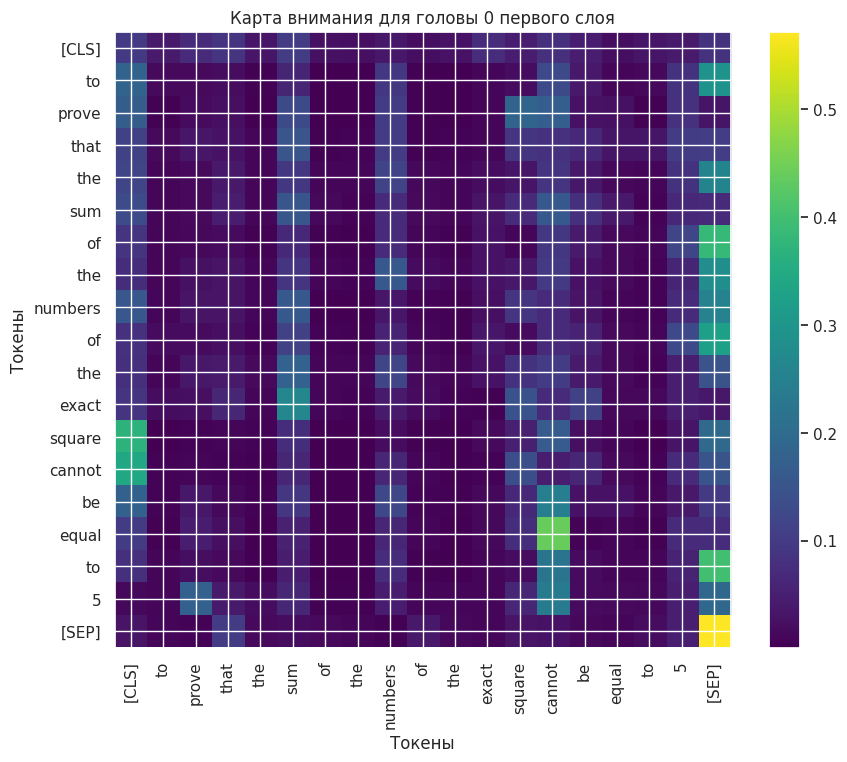

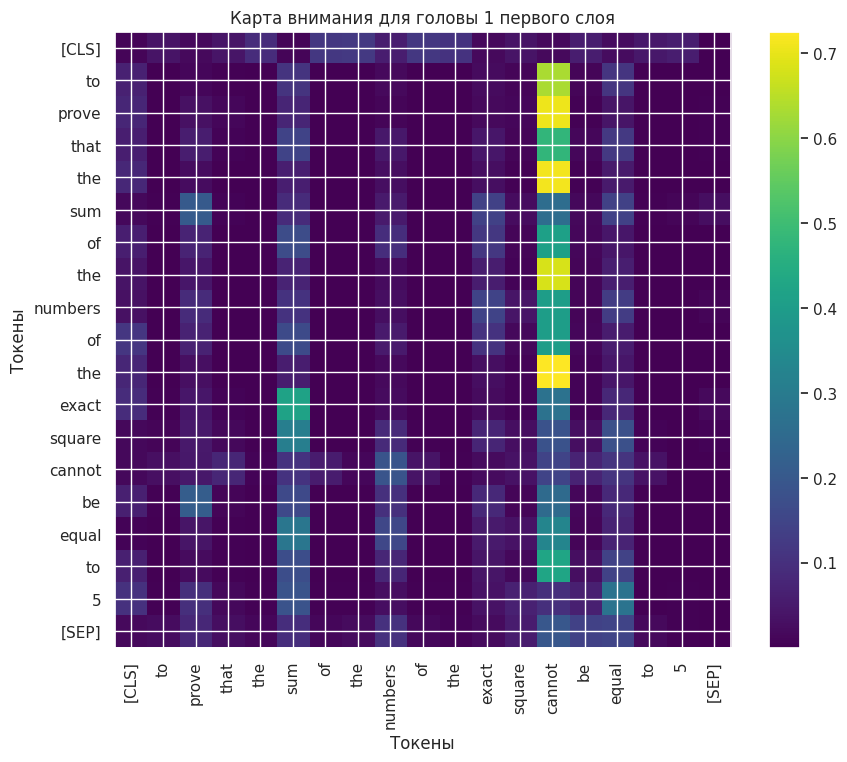

Текст: Find the product of all prime numbers less than 20

Карта внимания для дообученной модели RuBERT-tiny2


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


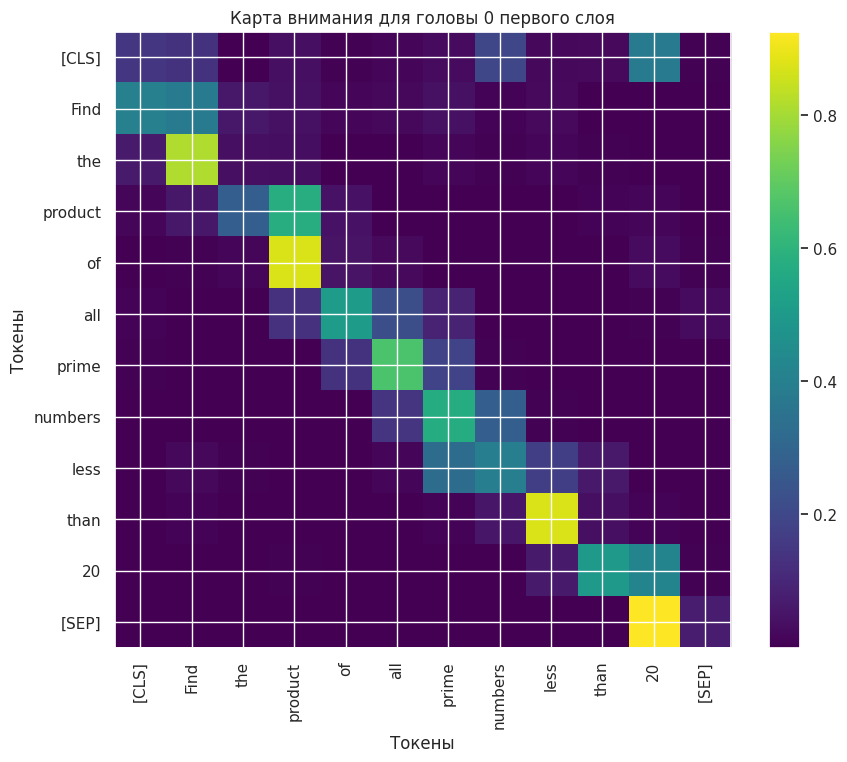

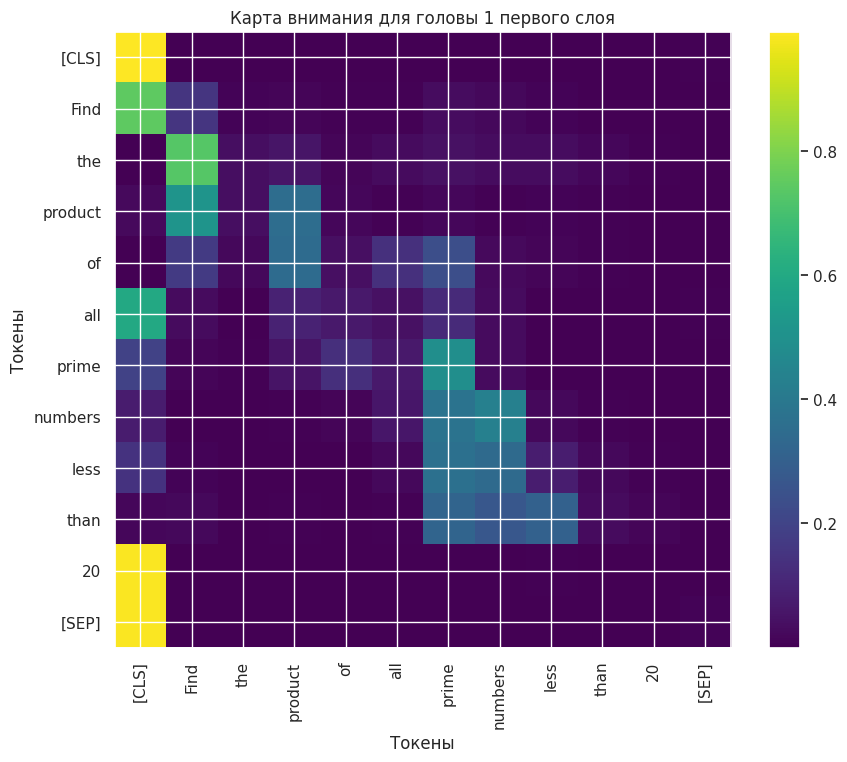

Карта внимания для дообученной модели MathBert


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


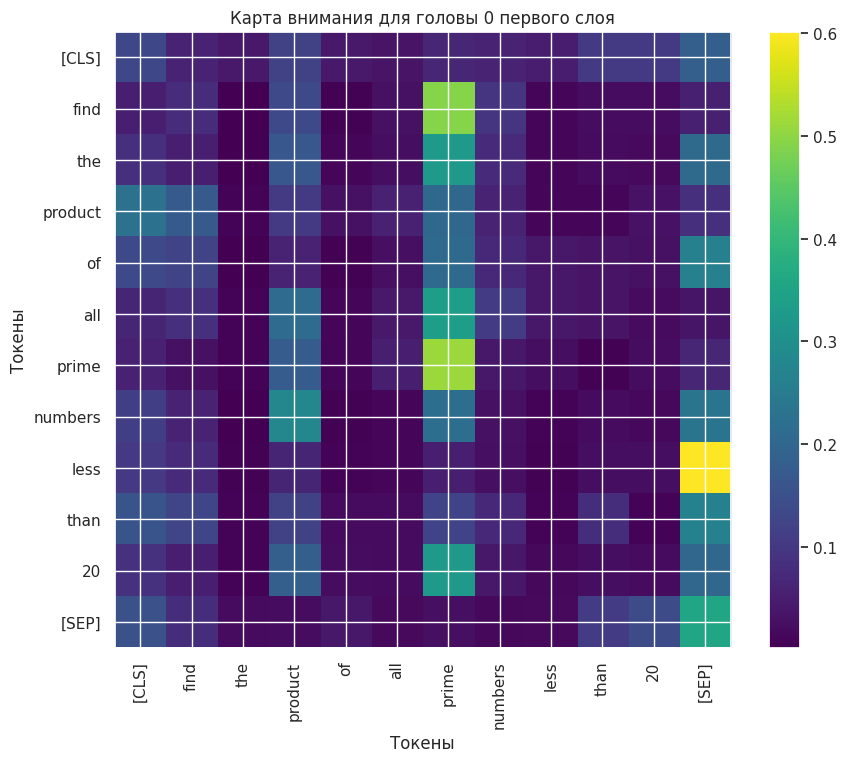

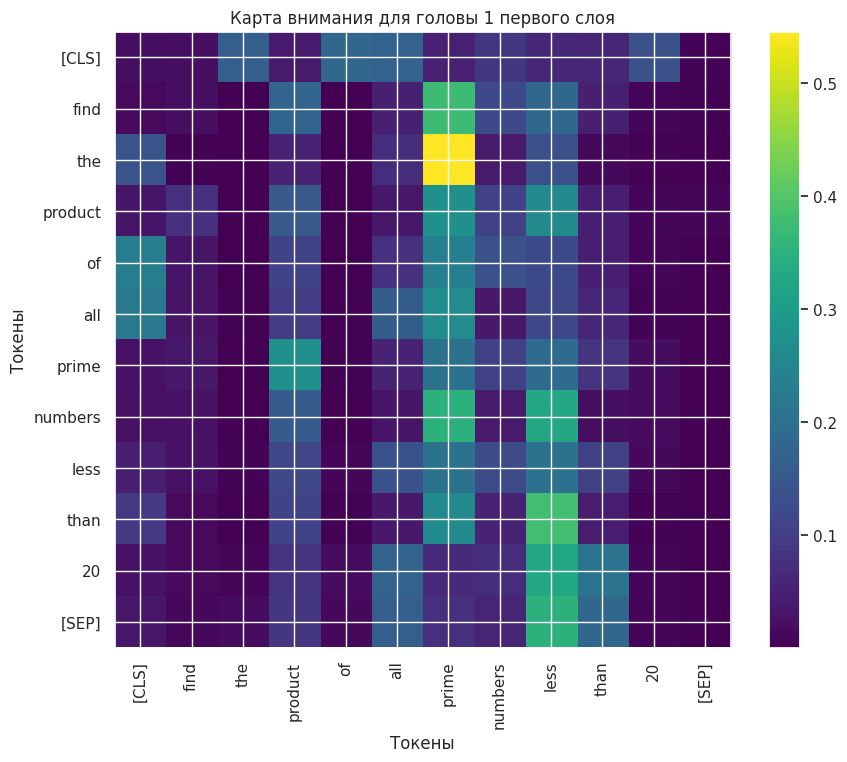

Текст: Show that every even integer greater than 2 can be written as the sum of two primes

Карта внимания для дообученной модели RuBERT-tiny2


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


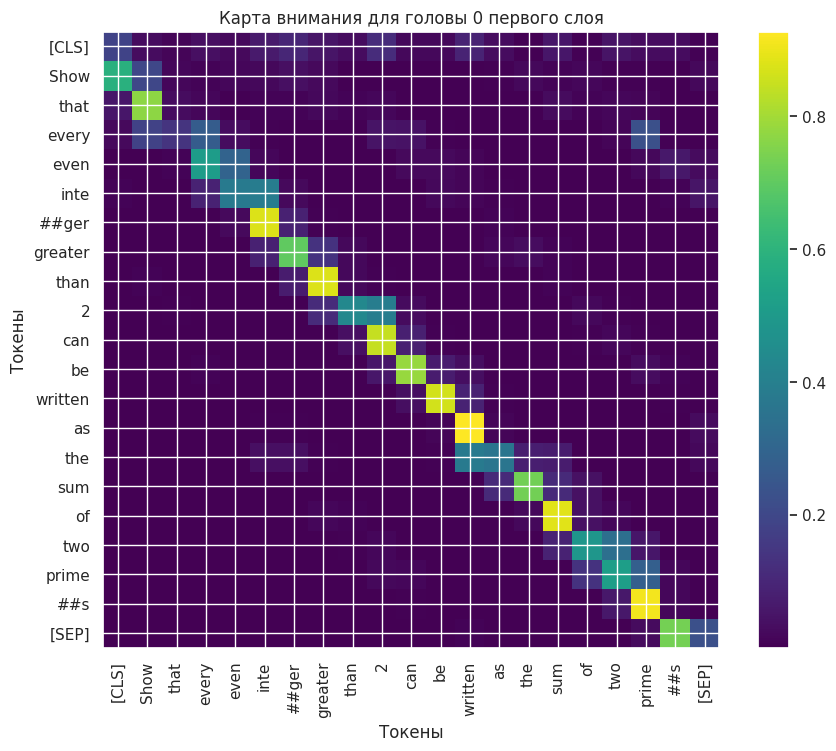

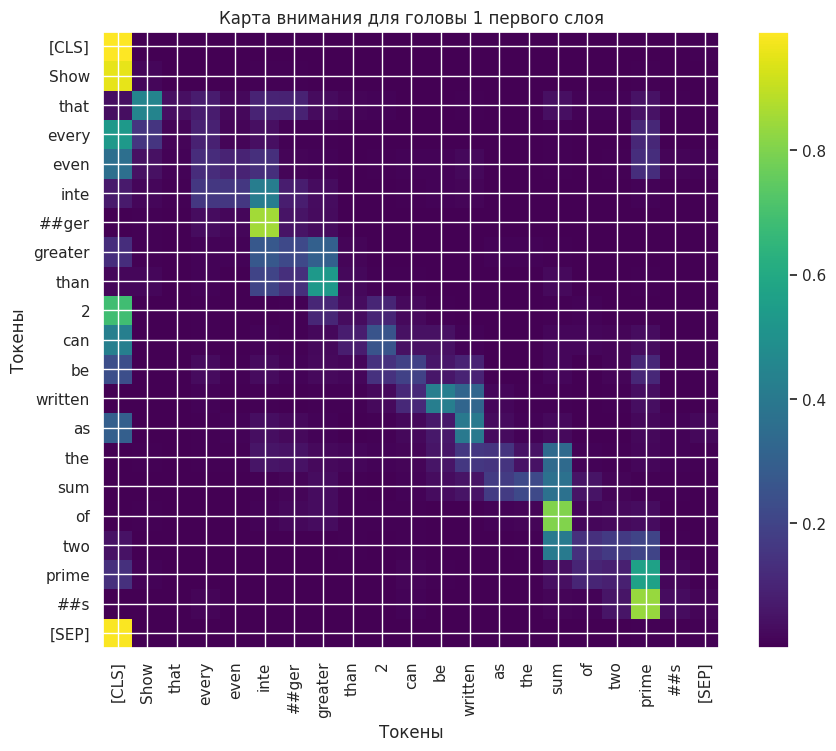

Карта внимания для дообученной модели MathBert


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


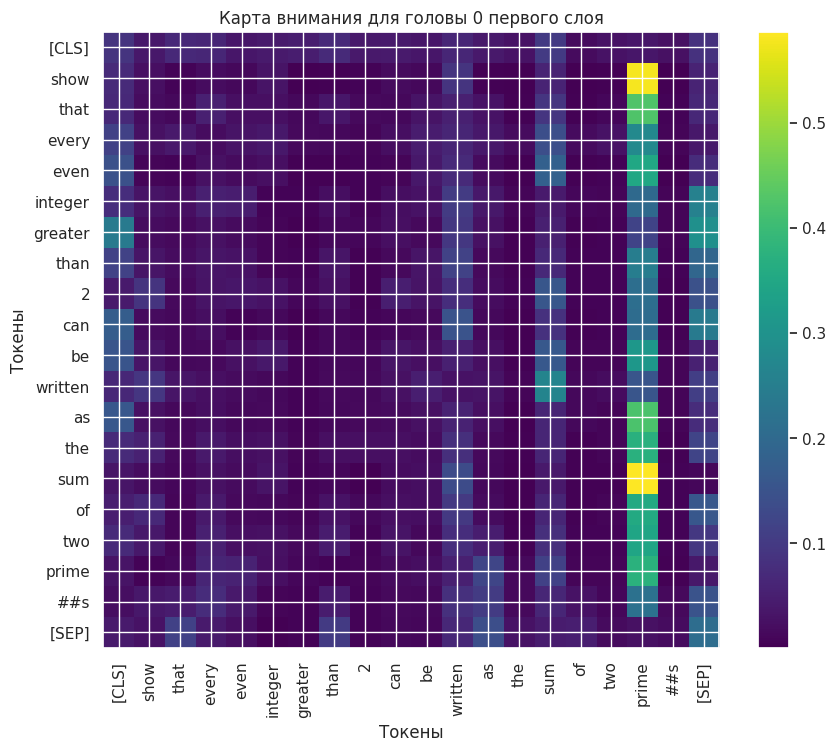

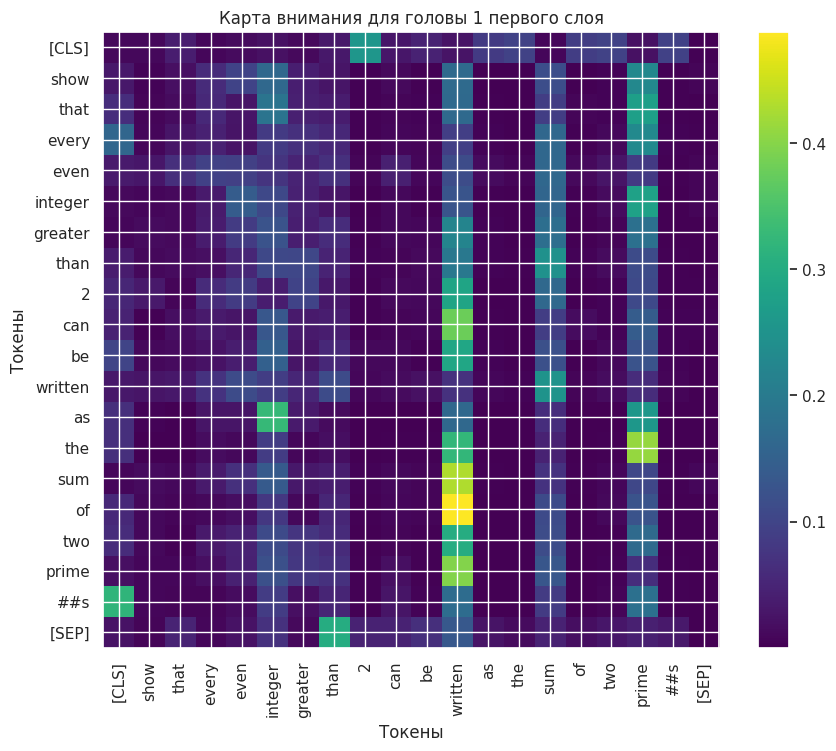

In [ ]:
for text in sample_texts:
    print(f"Текст: {text}\n")
    print("Карта внимания для дообученной модели RuBERT-tiny2")
    draw_first_layer_attention_maps(attention_head_ids=[0, 1], text=text, model=rubert_finetuned_model)

    print("Карта внимания для дообученной модели MathBert")
    draw_first_layer_attention_maps(attention_head_ids=[0, 1], text=text, model=mathbert_finetuned_model)

Видно, что с дообучением внимание стало еще больше фокусироваться на специфических для темы текста словах (sum, number, prime). Однако, видна также повышенная концетрация внимания на таких словах, как cannot, less и written. Следовательно, эти слова, несмотря на опосредованное отношение к предметной области, оказались очень важны для классификации темы.